In [2]:
import fastai.vision.all
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import time

In [3]:
# fastai.vision.all.defaults.device= torch.device('cpu')

In [4]:
class TMLP1(torch.nn.Module):
  def __init__(self, dim_in, dim_out, p=0.2):
    super(TMLP1,self).__init__()
    self.mlp= torch.nn.Sequential(
          torch.nn.Linear(dim_in, 600),
          torch.nn.ReLU(),
          torch.nn.Dropout(p),
          torch.nn.Linear(600, 600),
          torch.nn.ReLU(),
          torch.nn.Dropout(p),
          torch.nn.Linear(600, 600),
          torch.nn.ReLU(),
          torch.nn.Dropout(p),
          torch.nn.Linear(600, 600),
          torch.nn.ReLU(),
          torch.nn.Dropout(p),
          torch.nn.Linear(600, dim_out),
          )

  def forward(self, x):
    x= x.view(x.size(0), -1)
    return self.mlp(x)

In [5]:
path= fastai.vision.all.untar_data(fastai.vision.all.URLs.CIFAR)
# dblock= fastai.vision.all.DataBlock(blocks=(fastai.vision.all.ImageBlock(), fastai.vision.all.CategoryBlock()),
#                                     get_items=fastai.vision.all.get_image_files,
#                                     get_y=fastai.vision.all.parent_label,
#                                     item_tfms=fastai.vision.all.Resize(460),
#                                     batch_tfms=fastai.vision.all.aug_transforms(size=124, min_scale=0.75) )
dblock= fastai.vision.all.DataBlock(blocks=(fastai.vision.all.ImageBlock(), fastai.vision.all.CategoryBlock()),
                                    get_items=fastai.vision.all.get_image_files,
                                    get_y=fastai.vision.all.parent_label )
dls= dblock.dataloaders(path, bs=64)  #, cpu=True
path, dls.n, dls.c

(Path('/home/akihikoy/.fastai/data/cifar10'), 48000, 10)

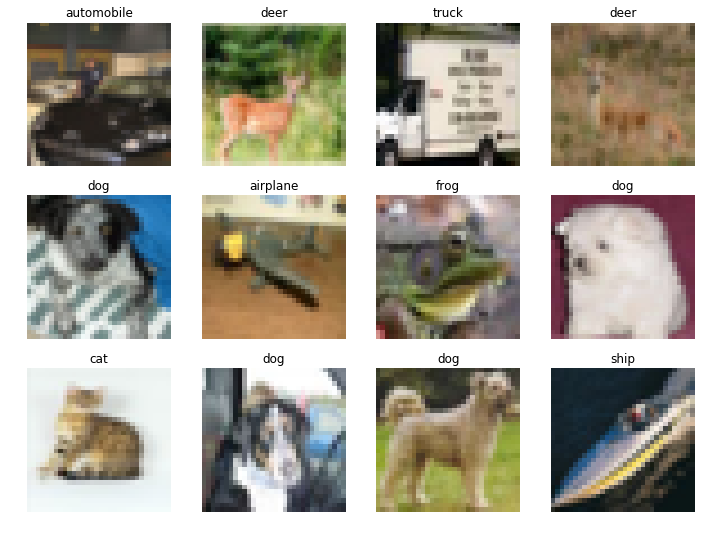

In [6]:
# x: Datasets
def show_grid(x, imgs, labels, ctxs=None, max_n=12, nrows=None, ncols=4, figsize=None, **kwargs):
    # if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = fastai.vision.all.get_grid(min(len(imgs), max_n), nrows=None, ncols=ncols, figsize=figsize)
    for ctx,img,label in zip(ctxs,imgs,labels):
        # x.show((img,label), ctx=ctx)
        i= img.clamp(0,1) if isinstance(img,torch.Tensor) else img
        t= x.vocab[label] if not isinstance(label,str) else str(label)
        fastai.vision.all.show_image(i, title=t, ctx=ctx, **kwargs)
b= dls.one_batch()
show_grid(dls, b[0], b[1])

In [7]:
dls.train_ds[0][1].device

device(type='cpu')

In [8]:
dls.train_ds[0][0].size

(32, 32)

In [9]:
img= torchvision.transforms.ToTensor()(dls.train_ds[0][0])
img.shape, img.numel()

(torch.Size([3, 32, 32]), 3072)

In [10]:
dls.train.one_batch()[0].shape

torch.Size([64, 3, 32, 32])

In [11]:
dls.train.one_batch()[0][0].shape, dls.train.one_batch()[0][0].numel()

(torch.Size([3, 32, 32]), 3072)

In [12]:
net= TMLP1(dls.train.one_batch()[0][0].numel(), dls.c)

In [13]:
learn= fastai.vision.all.Learner(dls, net, loss_func=fastai.vision.all.CrossEntropyLossFlat(), metrics=fastai.vision.all.accuracy)

In [14]:
# net(dls.dataset[0][0])
learn.predict(dls.dataset[0][0])

('cat',
 tensor(3),
 tensor([0.0986, 0.0973, 0.1000, 0.1026, 0.0973, 0.0999, 0.1015, 0.1022, 0.1001,
         0.1007]))

In [15]:
learn.summary()

TMLP1 (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 600            
Linear                                    1843800    True      
ReLU                                                           
Dropout                                                        
Linear                                    360600     True      
ReLU                                                           
Dropout                                                        
Linear                                    360600     True      
ReLU                                                           
Dropout                                                        
Linear                                    360600     True      
ReLU                                                           
Dropout                                                        
____________________________________________________________________________
                     64 x

SuggestedLRs(valley=0.0008317637839354575)

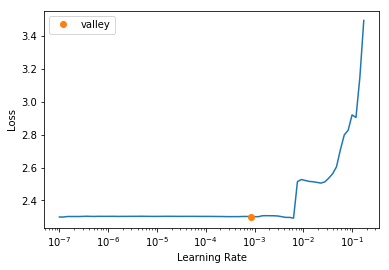

In [40]:
learn.lr_find()

In [16]:
learn.fit_one_cycle(10, 2.8e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.962818,1.900749,0.298500,00:06
1,1.829851,1.781806,0.355417,00:06
2,1.727759,1.642970,0.415000,00:06
3,1.638224,1.587731,0.422500,00:06
4,1.580092,1.526457,0.452417,00:06
5,1.507824,1.498757,0.464417,00:06
6,1.481116,1.451432,0.479667,00:06
7,1.448034,1.425486,0.491500,00:06
8,1.425619,1.403218,0.496833,00:06
9,1.383941,1.400087,0.500000,00:06


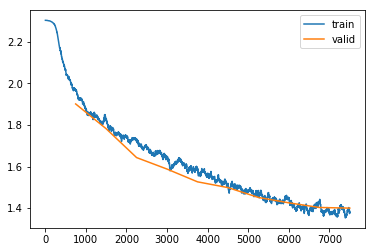

In [17]:
learn.recorder.plot_loss()

SuggestedLRs(valley=3.981071586167673e-06)

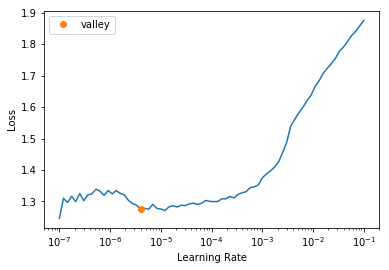

In [30]:
learn.lr_find()

In [31]:
learn.fit_one_cycle(5, 3.9e-06)

epoch,train_loss,valid_loss,accuracy,time
0,1.300222,1.356579,0.513917,00:06
1,1.315726,1.356052,0.517500,00:06
2,1.291586,1.352850,0.517500,00:06
3,1.289927,1.352471,0.517000,00:06
4,1.291505,1.351639,0.516750,00:06


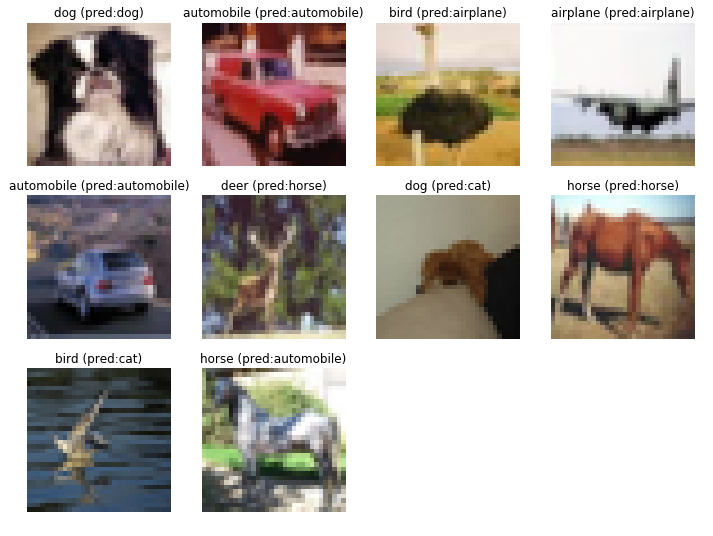

In [18]:
b= dls.dataset[np.random.permutation(len(dls.dataset))[:10]]
# learn.show_results()
# learn.predict(b[0][0].cpu())
# learn.get_preds(dl=b[0].cpu())
# net.eval()
# with torch.no_grad():
#     net(b[0][0])
# print([learn.predict(b[0][i].cpu()) for i in range(len(b[0]))])
# show_grid(dls, b[0], [learn.predict(img.cpu())[1] for img in b[0]])
# print(len(b))
# print(b[0][1], b[0][0], learn.predict(b[0][0]))
# print(b[1][1], b[1][0], learn.predict(b[1][0]))
show_grid(dls, [img for img,label in b], [f'{dls.vocab[label]} (pred:{learn.predict(img)[0]})' for img,label in b])

In [19]:
?learn.predict

Signature: learn.predict(item, rm_type_tfms=None, with_input=False)
Docstring: Prediction on `item`, fully decoded, loss function decoded and probabilities
File:      ~/.local/lib/python3.6/site-packages/fastai/learner.py
Type:      method
